In [3]:
!pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python matplotlib 

     -------------------------------------- 438.3/438.3 MB 2.1 MB/s eta 0:00:00
     -------------------------------------- 438.3/438.3 MB 1.8 MB/s eta 0:00:00
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
     ---------------------------------------- 5.8/5.8 MB 5.1 MB/s eta 0:00:00
     -------------------------------------- 462.3/462.3 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.8.0 which is incompatible.


In [207]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [208]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [132]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [3]:
pwd

'C:\\Users\\HP\\FaceID'

In [4]:
#uncompress Tar GZ Labelled faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
#Move lfw Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [133]:
#Import uuid libarary to generate unique image names 
import uuid

In [134]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3a2f51c1-89e6-11ed-b559-9078416df5c8.jpg'

In [118]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #Cut down frame to 250z250
    frame = frame[120:120+250,200:200+250, :]
    
    #Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)
        
    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
           # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Realease the webcam        
cap.release()
# Close the image frame
cv2.destroyAllWindows()

In [135]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [136]:
dir_test = anchor.as_numpy_iterator()

In [137]:
dir_test.next()

b'data\\anchor\\e74bf9ac-89e4-11ed-9ab4-9078416df5c8.jpg'

In [209]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    # Scale image between 0 and 1
    img = img / 255.0
    
    return img

In [210]:
img = preprocess(b'data\\anchor\\e74bf9ac-89e4-11ed-9ab4-9078416df5c8.jpg')

In [211]:
img.numpy().max() 

1.0

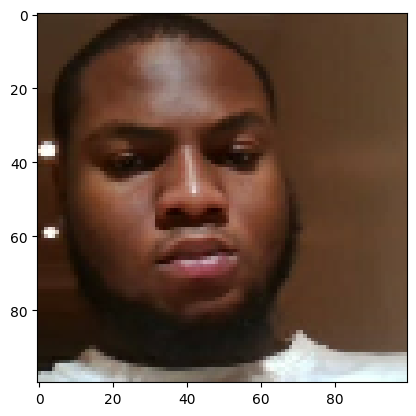

In [150]:
plt.imshow(img)

In [212]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [213]:
samples = data.as_numpy_iterator()

In [214]:
example = samples.next()

In [215]:
example

(b'data\\anchor\\fadc3c0e-89e4-11ed-8c30-9078416df5c8.jpg',
 b'data\\positive\\1757c3d1-89e5-11ed-9d11-9078416df5c8.jpg',
 1.0)

In [216]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [217]:
res = preprocess_twin(*example)

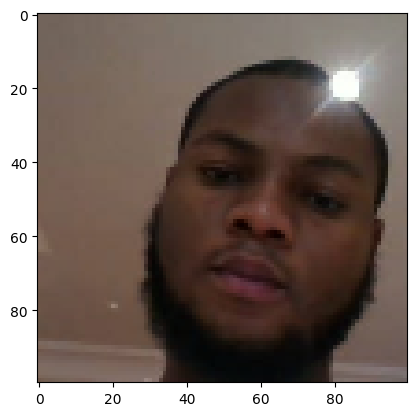

In [218]:
plt.imshow(res[1])

In [158]:
res[2]

1.0

In [159]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [160]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [161]:
train_samples = train_data.as_numpy_iterator()

In [162]:
train_sample = train_samples.next()

In [163]:
len(train_sample[0])

16

In [164]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [165]:
inp = Input(shape=(100,100,3), name='input_image')

In [166]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [167]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [168]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [169]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [170]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)


In [171]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_2')>

In [172]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [173]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [174]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [175]:
embedding = make_embedding()

In [176]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [219]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    #Init method inheritance 
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here     
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [220]:
l1 = L1Dist()

In [221]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [180]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [181]:
siamese_layer = L1Dist()

In [182]:
distances = siamese_layer(inp_embedding, val_embedding)

In [183]:
classifier = Dense(1, activation='sigmoid')(distances)

In [184]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [185]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [186]:
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [187]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_5')>

In [188]:
def make_siamese_model():
    
    # Anchor images input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
     # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [189]:
siamese_model = make_siamese_model()


In [190]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [191]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [192]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [193]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [194]:
test_batch = train_data.as_numpy_iterator()

In [195]:
batch_1 = test_batch.next()

In [196]:
X = batch_1[:2]


In [197]:
y = batch_1[2]


In [198]:
y

array([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [199]:
tf.losses.BinaryCrossentropy??


In [200]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss


In [201]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [107]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [108]:
EPOCHS = 50

In [209]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 583s 22s/step
0.6798769 0.63461536 0.9230769

 Epoch 2/50
27/27 [==============================] - 575s 21s/step
0.081129946 0.90384614 0.96410257

 Epoch 3/50
27/27 [==============================] - 578s 21s/step
0.025418121 0.97129184 0.98067635

 Epoch 4/50
27/27 [==============================] - 579s 21s/step
0.26832443 0.9906977 0.9953271

 Epoch 5/50
27/27 [==============================] - 570s 21s/step
0.00860762 0.9822222 0.9954955

 Epoch 6/50
27/27 [==============================] - 567s 21s/step
0.01361046 0.99122804 0.99559474

 Epoch 7/50
27/27 [==============================] - 571s 21s/step
0.014141951 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 573s 21s/step
0.00067909627 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 571s 21s/ste

In [210]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [211]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [212]:
y_hat = siamese_model.predict([test_input, test_val])

In [213]:
y_hat

array([[1.7063016e-08],
       [1.0000000e+00],
       [9.9999386e-01],
       [3.7357587e-08],
       [9.9999899e-01],
       [9.9999738e-01],
       [7.4983069e-07],
       [1.0000000e+00],
       [9.9999762e-01],
       [3.0328013e-09],
       [2.5958162e-08],
       [9.9999726e-01],
       [1.9117628e-07],
       [1.0000000e+00],
       [4.9997868e-09],
       [2.2538331e-06]], dtype=float32)

In [214]:
 # Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]

In [215]:
y_true


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [216]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [217]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

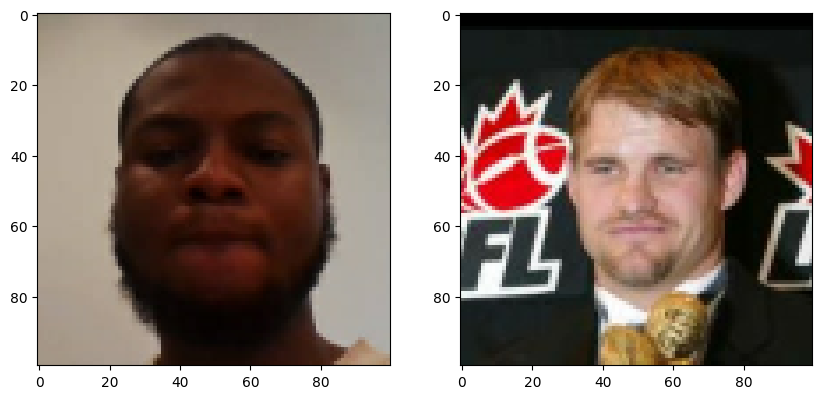

In [218]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [219]:
# Save weights
siamese_model.save('siamesemodelv2.h5')


In [220]:
L1Dist

__main__.L1Dist

In [222]:
# Reload model 
model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [223]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.1806922e-05],
       [6.0851661e-09],
       [9.9999940e-01],
       [5.3787109e-05],
       [1.0000000e+00],
       [1.2329787e-07],
       [8.0882614e-08],
       [2.8368000e-08],
       [9.9999821e-01],
       [9.9790180e-01],
       [1.7423524e-07],
       [9.9997914e-01],
       [9.9996841e-01],
       [3.4769320e-07],
       [2.0959973e-04],
       [9.9999976e-01]], dtype=float32)

In [223]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [224]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0c5a2c61-89e5-11ed-9c60-9078416df5c8.jpg',
 '0c9951a8-89e5-11ed-9e2e-9078416df5c8.jpg',
 '0cab41d0-89e5-11ed-9ce8-9078416df5c8.jpg',
 '0cb77b41-89e5-11ed-a712-9078416df5c8.jpg',
 '0dfae1bd-89e5-11ed-b032-9078416df5c8.jpg',
 '0e3595b0-89e5-11ed-ab51-9078416df5c8.jpg',
 '0ea20894-89e5-11ed-9243-9078416df5c8.jpg',
 '0f3d8f4c-89e5-11ed-bd21-9078416df5c8.jpg',
 '0fc0ce3b-89e5-11ed-bb7d-9078416df5c8.jpg',
 '0fd1f96f-89e5-11ed-8d9a-9078416df5c8.jpg',
 '0fd865ad-89e5-11ed-bed4-9078416df5c8.jpg',
 '0fdfbd13-89e5-11ed-899a-9078416df5c8.jpg',
 '0fe6cd19-89e5-11ed-a54c-9078416df5c8.jpg',
 '0febef18-89e5-11ed-88b3-9078416df5c8.jpg',
 '104eee75-89e5-11ed-812b-9078416df5c8.jpg',
 '106cd1d0-89e5-11ed-93fa-9078416df5c8.jpg',
 '108c752d-89e5-11ed-9054-9078416df5c8.jpg',
 '10a6632b-89e5-11ed-8ede-9078416df5c8.jpg',
 '158cabea-89e5-11ed-8904-9078416df5c8.jpg',
 '15e7604c-89e5-11ed-8fd8-9078416df5c8.jpg',
 '15f81383-89e5-11ed-8069-9078416df5c8.jpg',
 '16a3331e-89e5-11ed-be32-9078416df5c8.jpg',
 '16e858e5

In [225]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [226]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0c5a2c61-89e5-11ed-9c60-9078416df5c8.jpg
application_data\verification_images\0c9951a8-89e5-11ed-9e2e-9078416df5c8.jpg
application_data\verification_images\0cab41d0-89e5-11ed-9ce8-9078416df5c8.jpg
application_data\verification_images\0cb77b41-89e5-11ed-a712-9078416df5c8.jpg
application_data\verification_images\0dfae1bd-89e5-11ed-b032-9078416df5c8.jpg
application_data\verification_images\0e3595b0-89e5-11ed-ab51-9078416df5c8.jpg
application_data\verification_images\0ea20894-89e5-11ed-9243-9078416df5c8.jpg
application_data\verification_images\0f3d8f4c-89e5-11ed-bd21-9078416df5c8.jpg
application_data\verification_images\0fc0ce3b-89e5-11ed-bb7d-9078416df5c8.jpg
application_data\verification_images\0fd1f96f-89e5-11ed-8d9a-9078416df5c8.jpg
application_data\verification_images\0fd865ad-89e5-11ed-bed4-9078416df5c8.jpg
application_data\verification_images\0fdfbd13-89e5-11ed-899a-9078416df5c8.jpg
application_data\verification_images\0fe6cd19-89e5-11ed-a54c-907

In [227]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [228]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


True
False


In [229]:
np.squeeze(results) > 0.9

array([False, False, False, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])